In [1]:
import time
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import Imputer
%matplotlib inline

import sys
sys.path.append('../')
from pipeline import *
from onehot import *
from util import *
from null import *
from ordinal import *
from impute import *

d:\app\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train_data=pd.read_csv('raw_data/train.csv')
test_data=pd.read_csv('raw_data/test.csv')
train_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
test_data.describe(include=['O'])

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,8231,11456,11456,11456,11450,11456,11456
unique,3712,10575,2,5,45,913,277
top,Bella,2014-10-20 09:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,60,8,6656,4235,1768,3777,1219


In [4]:
train_data.describe(include=['O'])

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A681627,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [5]:
AGE_DAYS={'y':365,'m':30,'w':7,'d':1}
                
def dict_f(x):
    items=[]
    for a in x.split('/'):
        for b in a.split():
            items.append(b)
    return items
                

for df in (train_data,test_data):
    df['SexuponOutcome']=MixImputer().fit_transform(df[['SexuponOutcome']])
    df['AgeuponOutcome']=MixImputer().fit_transform(df[['AgeuponOutcome']])
    df['Sex1']=df['SexuponOutcome'].apply(lambda x : x if len(x.split()) == 1 else x.split()[1])
    df['Sex2']=df['SexuponOutcome'].apply(lambda x : np.nan if len(x.split()) == 1 else x.split()[0])
    df['Age']=df['AgeuponOutcome'].apply(lambda s: int(s.split()[0])*AGE_DAYS[s.split()[1][0]])
    
    for fe in ('Breed','Color'):
        for i in range(len(df)):
            items=dict_f(df.iloc[i][fe])
            for itm in items:
                if itm in df.columns:
                    df.iloc[i,fe+'_'+itm]=1
                else:
                    df[fe+'_'+itm]=0
    
train_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Color_Tiger,Color_Liver,Color_Apricot,Color_Lynx,Color_Lilac,Color_Gold,Color_Smoke,Color_Agouti,Color_Pink,Color_Ruddy
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0,0,0,0,0,0,0,0,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0,0,0,0,0,0,0,0,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0,0,0,0,0,0,0,0,0,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0,0,0,0,0,0,0,0,0,0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0,0,0,0,0,0,0,0,0,0


In [6]:
    
OUTCOME_TYPES=['Adoption','Died','Euthanasia','Return_to_owner','Transfer']
train_pipeline=DataFramePipeline([
    FeaturePipeline('OutcomeType','OutcomeType',Pipeline([('onehot',Ordinar(OUTCOME_TYPES))])),
    FeaturePipeline('Name','HasName',Pipeline([('name',NotNull())])),
    FeaturePipeline('AnimalType','',Pipeline([('onehot',LabelBinarizerEx(['AnimalType']))])),
    FeaturePipeline('Sex1','',Pipeline([('onehot',LabelBinarizerEx(['Sex1']))])),
    FeaturePipeline('Sex2','',Pipeline([('onehot',LabelBinarizerEx(['Sex2']))])),
    
])

train_p=train_pipeline.fit_transform(train_data)
train_target=train_p['OutcomeType']
train_pr=train_p.drop(['AnimalID','Name','DateTime','OutcomeType','OutcomeSubtype','AnimalType','SexuponOutcome','AgeuponOutcome','Breed','Color','Sex1','Sex2'],axis=1)
train_pr.head()

,Age,Breed_Shetland,Breed_Sheepdog,Breed_Mix,Breed_Domestic,Breed_Shorthair,Breed_Pit,Breed_Bull,Breed_Lhasa,Breed_Apso,...,Color_Ruddy,HasName,AnimalType_Cat,AnimalType_Dog,Sex1_Female,Sex1_Male,Sex1_Unknown,Sex2_Intact,Sex2_Neutered,Sex2_Spayed
0,365,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
1,365,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,1
2,730,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
3,21,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
4,730,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


d:\app\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


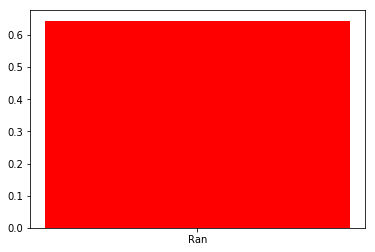

[('Ran', 0.64454358547673396)]


In [7]:
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

base_clfs=[
#       LogisticRegression(n_jobs=-1),
#       SVC(probability=True),
      RandomForestClassifier(n_jobs=-1),
#       GradientBoostingClassifier(),
#       AdaBoostClassifier(), 
#       ExtraTreesClassifier(n_jobs=-1), 
#       XGBClassifier(),
]

from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

def trainModels(train_data, target):
    scores=[cross_val_score(clf,train_data,target,scoring='accuracy',cv=5,n_jobs=-1,verbose=1).mean() for clf in base_clfs]

    labels=[c.__class__.__name__[:3] for c in base_clfs]
    X=np.arange(len(base_clfs))
    bar(X,scores,tick_label=labels,color='rgb')
    show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))
    
trainModels(train_pr,train_target)
    

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid_set=[
#                 {'C':[0.01,0.1,0.5,1.]},
#                 {'C':[1.,10.,],'kernel':['rbf','poly'],'gamma':[0.01,0.1,1.],'coef0':[1.,10.,]},
                {'n_estimators':[100,500,1000,3000],'max_depth':[5,10,15]},
#     {'n_estimators':[100],'max_depth':[5]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300],'max_depth':[3,5,8]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300]},
#                 {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,300,500],'max_depth':[5,10,15],'gamma':[0.01,0.1,0.5]},
               ]

def tuneModels(train_data,target):
    results=[]
    for i in range(len(base_clfs)):
        gs=GridSearchCV(estimator=base_clfs[i],param_grid=param_grid_set[i],scoring='accuracy',n_jobs=-1,verbose=1,cv=5)
        gs.fit(train_data,target)
        results.append((gs.best_estimator_,gs.best_score_))
    results=sorted(results,key=lambda x:x[1],reverse=True)
    return results

results=tuneModels(train_pr,train_target)
best_clf=results[0][0]
print(results)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.4min finished


[(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 0.64551610610198662)]


In [9]:
# t=time.time()
# best_clf=RandomForestClassifier(n_estimators=2000,n_jobs=-1,max_depth=15)
# best_clf.fit(train_pr,train_target)
# int(time.time()-t),best_clf.score

In [10]:
# best_clf.score(train_pr,train_target)

In [11]:
# dir(GradientBoostingClassifier)

In [12]:
test_id=test_data['ID']
test_pipeline=DataFramePipeline(train_pipeline.pipelines[1:])
test_p=test_pipeline.transform(test_data)
test_pr=test_p.drop(['ID','Name','DateTime','AnimalType','SexuponOutcome','AgeuponOutcome','Breed','Color','Sex1','Sex2'],axis=1)
predicts=best_clf.predict_proba(test_pr)
submission=pd.concat([test_data[['ID']],pd.DataFrame(predicts,columns=OUTCOME_TYPES)],axis=1)
submission.to_csv('output/result.csv',index=False)

ValueError: Number of features of the model must match the input. Model n_features is 308 and input n_features is 291 